# Document Scanner
Source: https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/

# 4 Point Transformation
source: [https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/](https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/)

In [1]:
# import the necessary packages
import numpy as np
import cv2
 
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [2]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils

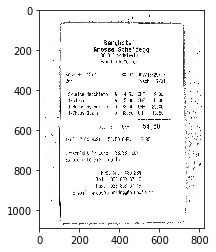

In [15]:
img = plt.imread('out_sample.jpg')

plt.imshow(img, 'gray')

In [27]:
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

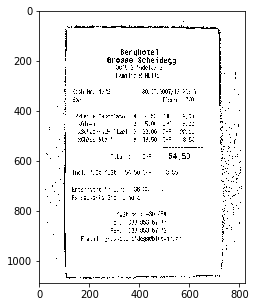

In [31]:
plt.figure(figsize=(5, 5))
plt.imshow(th1, 'gray')

Not gray
STEP 1: Edge Detection


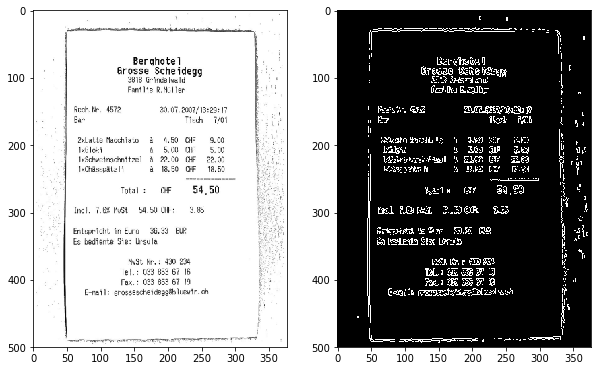

In [57]:
image = img # cv2.imread(args["image"])
ratio = image.shape[0] / 400.0
orig = image.copy()
image = imutils.resize(image, height = 500)
 
# convert the image to grayscale, blur it, and find edges
# in the image

try:
    # gray
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
except:
    print("Not gray")
    

blur = cv2.GaussianBlur(image, (3, 3), 0)
edged = cv2.Canny(blur, 75, 200)

# show the original image and the edge detected image
print("STEP 1: Edge Detection")


images = [image, edged]


columns = len(images)
plt.figure(figsize=(10, 15))
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image, 'gray')

In [52]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

screenCnt = None
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    print('lenght of approx {}'.format(len(approx)))
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break

# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
cv2.imshow("Outline", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
if screenCnt:
    print('----')
else:
    print("Not able to find - screenCnt\n" * 5 ) 

lenght of approx 8
lenght of approx 15
lenght of approx 10
lenght of approx 14
lenght of approx 13
STEP 2: Find contours of paper


error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/drawing.cpp:2612: error: (-215:Assertion failed) reader.ptr != __null in function 'cvDrawContours'


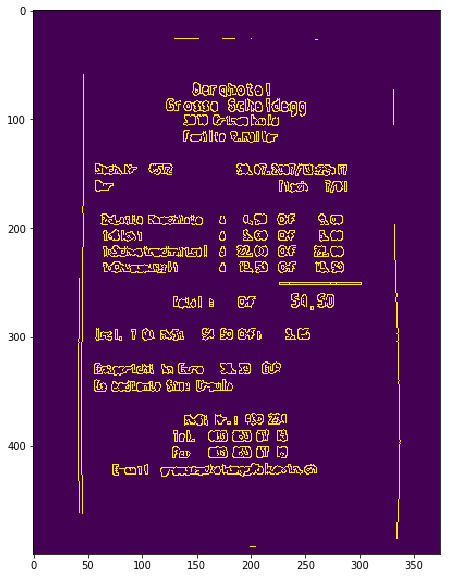

In [21]:
plt.figure(figsize=(10,10))

plt.imshow(image)

In [22]:
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
 
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
# T = threshold_local(warped, 11, offset = 10, method = "gaussian")
# warped = (warped > T).astype("uint8") * 255
 
# show the original and scanned images
print("STEP 3: Apply perspective transform")
cv2.imshow("Original", imutils.resize(orig, height = 650))
cv2.imshow("Scanned", imutils.resize(warped, height = 650))
cv2.waitKey(0)

NameError: name 'four_point_transform' is not defined

In [ ]:
plt.figure(figsize=(40,20))
plt.imshow(imutils.resize(orig, height = 650))

In [ ]:
plt.figure(figsize=(40,20))
plt.imshow(imutils.resize(warped, height = 650))

In [ ]:
imutils.resize(warped, height = 650)

In [ ]:
plt.imsave('scanned.png', imutils.resize(warped, height = 650))

In [ ]:
!open scanned.png